# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>

In [16]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
import time
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [17]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
#mean = np.random.uniform(-0.0005, 0.0005, N)
#A = np.random.uniform(0, 0.0113, size=(N, N))
mean = np.random.rand(N)
A = np.random.rand(N, N)
cov = np.dot(A, A.transpose())

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

print('multivariate normal shape =', data.shape)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
scalefactor = 1
expected_return = ExpectedReturn(method='arithmetic', scalefactor = scalefactor)
q =  expected_return.estimate(df, inplace = False)

# Compute the covariance matrix from df
covariance = Covariance(method='pearson')
P = covariance.estimate(df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)


multivariate normal shape = (1000, 100)
Vector of expected returns (q):
Asset_1      0.112445
Asset_2      0.241188
Asset_3      0.980662
Asset_4      1.035154
Asset_5      0.702124
               ...   
Asset_96     0.394133
Asset_97     0.781312
Asset_98     0.836621
Asset_99     0.391693
Asset_100    0.285944
Length: 100, dtype: float64

Covariance matrix (P):
             Asset_1    Asset_2    Asset_3    Asset_4    Asset_5    Asset_6  \
Asset_1    34.803898  28.200260  26.205325  28.696082  27.774153  28.494937   
Asset_2    28.200260  36.584348  27.684640  29.325672  28.911716  31.654527   
Asset_3    26.205325  27.684640  34.636670  29.216113  28.203434  31.203123   
Asset_4    28.696082  29.325672  29.216113  39.555080  31.257528  33.985948   
Asset_5    27.774153  28.911716  28.203434  31.257528  37.947819  31.805853   
...              ...        ...        ...        ...        ...        ...   
Asset_96   26.122005  28.623865  27.387608  27.638285  28.392670  31.186069   
As

In [18]:
# average return over all assets
print(q.mean(axis=0))

0.5538166560614514


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [19]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(np.zeros((3, N)), columns = constraints.ids)
G.iloc[0, 0:30] = 1
G.iloc[1, 30:60] = 1
G.iloc[2, 60:] = 1
h = pd.Series([0.3, 0.4, 0.5])

constraints.add_linear(G=G, rhs=h, sense='<=')

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [20]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results

#solver_array = qpsolvers.available_solvers # array of available solvers
solver_array = list(USABLE_SOLVERS)
print(solver_array)

data = {
    'solution_found': [False]*len(solver_array),
    'objective': [None] * len(solver_array),
    'primal_residual': [float('nan')] * len(solver_array),
    'dual_residual': [float('nan')] * len(solver_array),
    'duality_gap': [float('nan')] * len(solver_array),
    'runtime': [float('nan')] * len(solver_array),
}
Results_df  = pd.DataFrame(solver_array, index=data)
Results_df = Results_df.drop(Results_df.columns[0], axis=1)

risk_aversion = 1

for solver in solver_array:
    qp = QuadraticProgram(
        P = P.to_numpy() * risk_aversion,
        q = q.to_numpy() * -1,
        G = GhAb['G'],
        h = GhAb['h'],
        A = GhAb['A'],
        b = GhAb['b'],
        lb = constraints.box['lower'].to_numpy(),
        ub = constraints.box['upper'].to_numpy(),
        solver = solver
    )
    
    start_time = time.time()
    qp.solve()
    end_time = time.time()

    execution_time = end_time - start_time

    solution = qp.results.get('solution')
    Results_df.loc['solution_found', solver] = solution.found

    if solution.found:
        Results_df.loc['objective', solver] = qp.objective_value()
        Results_df.loc['primal_residual', solver] = solution.primal_residual()
        Results_df.loc['dual_residual', solver] = solution.dual_residual()
        Results_df.loc['duality_gap', solver] = solution.duality_gap()
        Results_df.loc['runtime', solver] = execution_time

['highs', 'cvxopt', 'quadprog', 'osqp', 'qpalm', 'daqp']


Print and visualize the results

,highs,cvxopt,quadprog,osqp,qpalm,daqp
solution_found,True,True,True,True,True,True
objective,10.505199,10.5052,10.505199,10.452521,10.504199,10.505199
primal_residual,0.0,0.0,0.0,0.000923,0.000034,0.0
dual_residual,0.0,0.0,0.0,0.001187,0.0,0.0
duality_gap,1.4177211238308729e-08,1.2206303613981895e-06,5.006162151488525e-12,0.05059103136005161,0.0009996687151017647,1.8960388814548423e-12
runtime,0.005991,0.055282,0.005513,0.003998,0.00554,0.002008


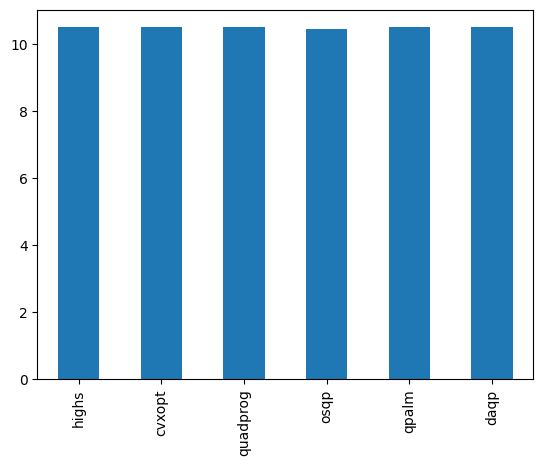

In [21]:
#<your code here>
Results_df.loc['objective'].plot(kind='bar')

Results_df

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [ ]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
#<your code here>

# Instantiate the MinVariance class
#<your code here>

# Prepare the optimization data and prepare the optimization problem
#<your code here>

# Solve the optimization problem and print the weights
#<your code here>